# Проект: вариант 1    
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1.В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.    
2.Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.    
3.Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

In [1]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from datetime import datetime
from datetime import timedelta
from tqdm.auto import tqdm
import pingouin as pg
from scipy.stats import norm

# Задание 1    
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

Считаем исходные данные

In [ ]:
reg_data = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Qb0QI44Zs2GiiA' ,sep=';')
reg_data

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [1]:
auth_data = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/e9BGukZuL0wDgA',sep=';')
auth_data

NameError: name 'pd' is not defined

Посмотрим типы переменных, наличие пропущенных и уникальных значений и описательную статистику

In [4]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [5]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [6]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [7]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [8]:
reg_data.reg_ts.nunique()

1000000

In [9]:
auth_data["uid"].nunique()

1000000

In [10]:
reg_data.describe()

,reg_ts,uid
count,1.000000e+06,1.000000e+06
mean,1.548332e+09,5.552354e+05
std,5.253653e+07,3.206011e+05
min,9.113822e+08,1.000000e+00
25%,1.528034e+09,2.776438e+05
50%,1.564454e+09,5.550455e+05
75%,1.585759e+09,8.329712e+05
max,1.600874e+09,1.110622e+06


In [11]:
auth_data.describe()

,auth_ts,uid
count,9.601013e+06,9.601013e+06
mean,1.548778e+09,3.347198e+05
std,5.160527e+07,2.832669e+05
min,9.113822e+08,1.000000e+00
25%,1.528375e+09,9.599700e+04
50%,1.564577e+09,2.579210e+05
75%,1.585823e+09,5.190250e+05
max,1.600874e+09,1.110622e+06


In [12]:
pd.to_datetime(reg_data.reg_ts.min(), unit='s') # минимальное значение даты регистрации

Timestamp('1998-11-18 09:43:43')

In [13]:
pd.to_datetime(reg_data.reg_ts.max(), unit='s') # максимальное значение даты регистрации

Timestamp('2020-09-23 15:17:24')

In [14]:
pd.to_datetime(auth_data.auth_ts.min(), unit='s')  # минимальное значение даты захода в игру

Timestamp('1998-11-18 09:43:43')

In [15]:
pd.to_datetime(auth_data.auth_ts.max(), unit='s')  # максимальное значение даты захода в игру

Timestamp('2020-09-23 15:17:24')

Функция для нахождения retention по дням

In [16]:
# auth и reg - это исходные файлы с данными
# start и end - это даты искомого диапазона когорт
# ret_days - это кол-во дней для retention
def retention(auth, reg, start, end, ret_days):
    # объединяем оба датафрейма с данными
    df = auth.merge(reg, on='uid')
        
    # добавляем столбцы в нужном формате и удаляем ненужные столбцы
    df['action_date'] = pd.to_datetime(df.auth_ts, unit='s').dt.date
    df['cohort_date'] = pd.to_datetime(df.reg_ts, unit='s').dt.date
    df.drop(['reg_ts', 'auth_ts'], axis=1, inplace=True)
    
    # находим разницу в днях между датой регистрации и датой авторизаций
    df['days_diff'] = (df.action_date - df.cohort_date).dt.days.astype('int16')
    
    # фильтруем нужные данные
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    df_cut = df[(df['cohort_date'] >= start) & (df['cohort_date'] <= end) & (df['days_diff'] <= ret_days)] 
    
    # находим кол-во авторизаций для каждого набора значений и добавляем аналогичный столбец с разницей в днях
    cohorts = df_cut.groupby(['cohort_date', 'action_date'], as_index=False).uid.nunique()
    cohorts['days_diff'] = (cohorts.action_date - cohorts.cohort_date).dt.days
            
    # формируем сводную таблицу и строим retention с помощью деления всех значений на размер когорт
    cohort_pivot = cohorts.pivot_table(index='cohort_date', columns='days_diff', values='uid')
    retention_matrix = cohort_pivot.div(cohort_pivot.iloc[:, 0], axis=0).round(3)
    
    # строим heatmap
    plt.figure(figsize=(20, 15))
    ax = sns.heatmap(retention_matrix, cmap='PiYG', annot=True, fmt='.2%', vmax=0.1, cbar=False)
    ax.set_title('Retention rate {} days'.format(ret_days), fontsize=30)
    plt.ylabel('Cohort', fontsize=20) 
    plt.xlabel('Days after registration', fontsize=20)
    sns.despine()

    return retention_matrix

days_diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
cohort_date,,,,,,,,,,,,,,,,
2020-01-10,1.0,0.019,0.037,0.051,0.043,0.059,0.071,0.056,0.045,0.048,0.045,0.052,0.049,0.037,0.038,0.059
2020-01-11,1.0,0.016,0.039,0.051,0.050,0.048,0.064,0.057,0.044,0.053,0.054,0.044,0.048,0.040,0.046,0.040
2020-01-12,1.0,0.019,0.045,0.041,0.056,0.070,0.059,0.048,0.051,0.056,0.043,0.060,0.042,0.037,0.043,0.044
2020-01-13,1.0,0.019,0.044,0.048,0.057,0.057,0.069,0.063,0.030,0.069,0.050,0.047,0.043,0.062,0.048,0.049
2020-01-14,1.0,0.017,0.045,0.054,0.065,0.056,0.065,0.063,0.072,0.041,0.061,0.059,0.055,0.061,0.052,0.049
2020-01-15,1.0,0.016,0.042,0.056,0.057,0.047,0.059,0.073,0.052,0.050,0.043,0.052,0.049,0.057,0.047,0.041
2020-01-16,1.0,0.023,0.041,0.048,0.058,0.062,0.070,0.059,0.043,0.058,0.063,0.050,0.057,0.051,0.037,0.057
2020-01-17,1.0,0.020,0.035,0.039,0.049,0.048,0.064,0.049,0.051,0.039,0.049,0.043,0.039,0.046,0.038,0.040
2020-01-18,1.0,0.031,0.042,0.047,0.051,0.066,0.074,0.070,0.046,0.036,0.059,0.064,0.049,0.051,0.048,0.045


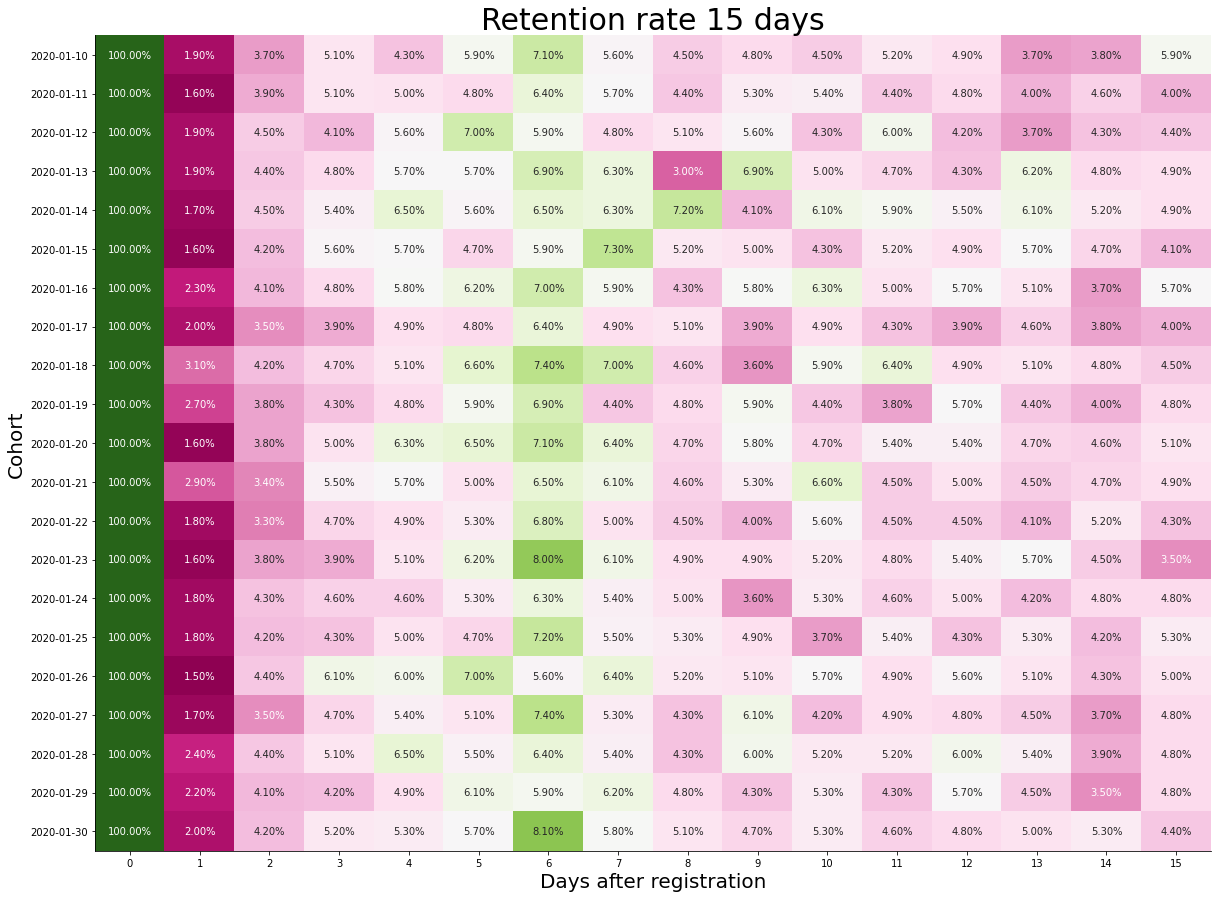

In [17]:
retention(auth_data, reg_data, '2020-01-10', '2020-01-30', 15)

__Вывод:__ самый высокий показатель retention в среднем на 6-й день. Если посмотреть в целом, то показатель возвращаемости игроков низкий. Можно добавить бонусы за ежедневное посещение игры или ежедневного события.

---

# Задание 2    
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Считаем исходные данные

In [ ]:
df_ab_test = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/SOkIsD5A8xlI7Q, sep=';')

Посмотрим на получившийся датафрейм и проверим, нет ли пропусков дубликатов, а так же посмотрим описательную статистику revenue.

In [19]:
df_ab_test.head(5)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


Проверим на пропуски и тип данных

In [20]:
df_ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


Проверим на наличие дубликатов

In [21]:
df_ab_test.loc[df_ab_test.duplicated()]

,user_id,revenue,testgroup


Посмотрим описательную статистику

In [22]:
df_ab_test.revenue.describe()

count    404770.000000
mean         26.083435
std         681.652928
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

Дубликатов и пропусков нет.
Определим, какая группа контрольная, какая тестовая и посмотрим на значения каждой из них

In [23]:
df_ab_test.loc[df_ab_test.testgroup == 'a'].shape

(202103, 3)

In [24]:
df_ab_test.loc[df_ab_test.testgroup == 'b'].shape

(202667, 3)

Опираясь на условие, получается, что группа 'а' - контрольная, а группа 'b' - тестовая

Разделим данные по группам

In [25]:
control_group = df_ab_test.loc[df_ab_test.testgroup == 'a']
test_group = df_ab_test.loc[df_ab_test.testgroup == 'b']

Посмотрим на распределение в группах

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


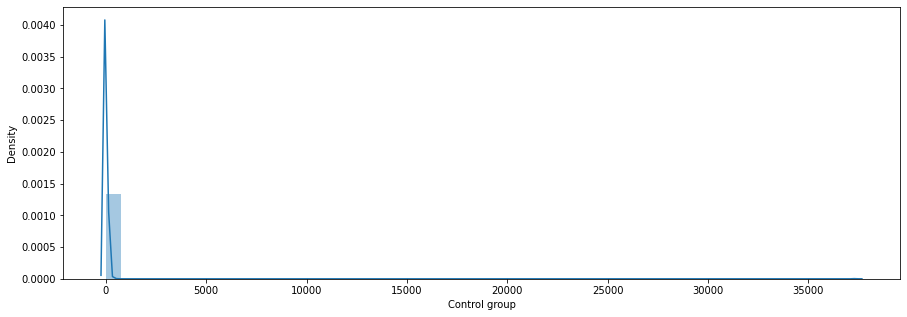

In [26]:
plt.figure(figsize=(15, 5))
sns.distplot(control_group.revenue)
plt.xlabel('Control group')
plt.show()

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


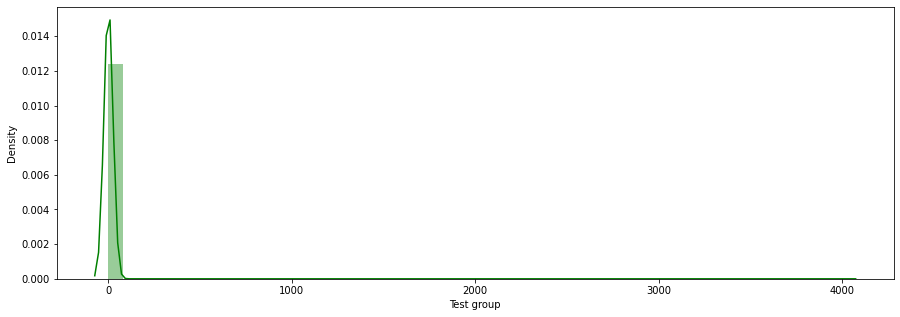

In [27]:
plt.figure(figsize=(15, 5))
sns.distplot(test_group.revenue, color='green')
plt.xlabel('Test group')
plt.show()

Проверим данные на нормальность распределения 

In [28]:
pg.normality(df_ab_test, dv='revenue', group='testgroup', method='normaltest')

,W,pval,normal
b,326622.395409,0.0,False
a,585152.731273,0.0,False


Распределения не нормальные

Отбираем пользователей, которые совершали покупки (revenue > 0)

In [29]:
control = control_group.loc[control_group.revenue > 0]
test = test_group.loc[test_group.revenue > 0]

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


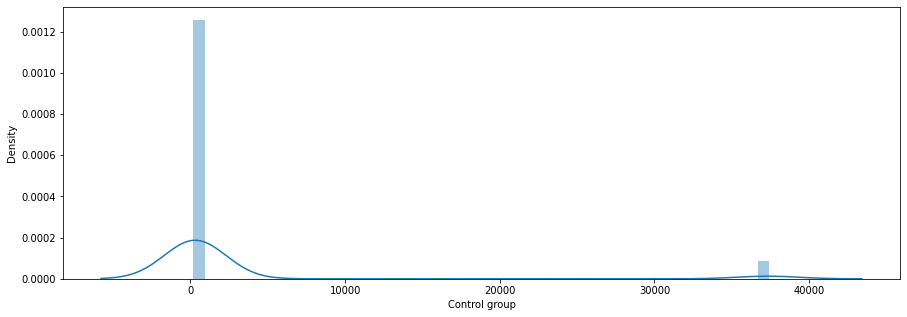

In [30]:
plt.figure(figsize=(15, 5))
sns.distplot(control.revenue)
plt.xlabel('Control group')
plt.show()

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


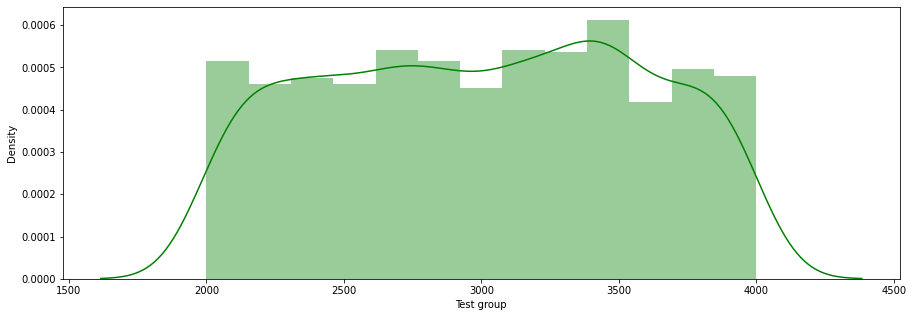

In [31]:
plt.figure(figsize=(15, 5))
sns.distplot(test.revenue, color='green')
plt.xlabel('Test group')
plt.show()

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


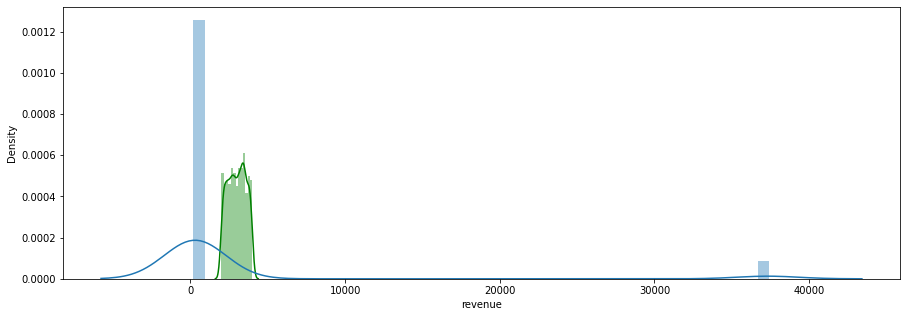

In [32]:
plt.figure(figsize=(15, 5))
sns.distplot(test.revenue, color='green') # тестовая группа
sns.distplot(control.revenue) # контрольная группа
plt.show()

Согласно графикам в обеих группах распределение не нормальное

Проверим расчетами распределение на нормальность для покупателей, совершивших покупки:

In [33]:
pg.normality(df_ab_test.loc[df_ab_test.revenue > 0], dv='revenue', group='testgroup', method='normaltest')

,W,pval,normal
a,1394.945784,1.234161e-303,False
b,1068.860008,7.943249e-233,False


Проверим гомоскедастичность дисперсий с помощью критерия Левена

In [34]:
pg.homoscedasticity(data=df_ab_test.loc[df_ab_test.revenue > 0], dv='revenue', group='testgroup')

,W,pval,equal_var
levene,80.855674,3.779690e-19,False


Графики и расчеты подтверждают, что распределения в обеих группах не нормальные и не гомоскедастичны

Посмотрим на такие метрики, как среднее значение, медиану, конверсию, ARPU и ARPPU

In [35]:
metrics = pd.DataFrame(columns=['test', 'control'])

#Среднее   
test_mean = test.revenue.mean()
control_mean = control.revenue.mean()
metrics = metrics.append({'test':test_mean,'control':control_mean}, ignore_index=True)

#Медиана
test_median = np.median(test['revenue'])
control_median = np.median(control['revenue'])
metrics = metrics.append({'test':test_median,'control':control_median}, ignore_index=True)

#Конверсия
test_conv = (test.shape[0]/test_group.shape[0])*100
control_conv = (control.shape[0]/control_group.shape[0])*100
metrics = metrics.append({'test':test_conv,'control':control_conv}, ignore_index=True)

#ARPU
test_arpu = test_group.revenue.sum()/test_group.shape[0]
control_arpu = control_group.revenue.sum()/control_group.shape[0]
metrics = metrics.append({'test':test_arpu,'control':control_arpu}, ignore_index=True)

#ARPPU
test_arppu = test.revenue.sum()/test.shape[0]
control_arppu = control.revenue.sum()/control.shape[0]
metrics = metrics.append({'test':test_arppu,'control':control_arppu}, ignore_index=True) 

new_index = ['Mean', 'Median', 'Conversion', 'ARPU', 'ARPPU']
metrics.index = new_index

metrics.apply(lambda x : round(x, 2))

,test,control
Mean,3003.66,2664.00
Median,3022.00,311.00
Conversion,0.89,0.95
ARPU,26.75,25.41
ARPPU,3003.66,2664.00


Т.к. обе группы не имеют нормального распределения и нет гомоскедастичности, и, с учетом того, чтобы бизнесу было легче объяснить результаты исследования, для сравнения будем использовать bootstrap (с mean). 

Гипотезы:    
Н0 - разница в средних значениях в обоих группах отсутствует (при p > 0.05)    
Н1 - разница есть (при p < 0.05)

In [36]:
def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it=1000, 
    statistic=np.mean,
    bootstrap_conf_level=0.95
):
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True 
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values

        '''mean() - применяем статистику'''
        boot_data.append(statistic(samples_1) - statistic(samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    '''Визуализация '''
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

Применим функцию bootstrap'a

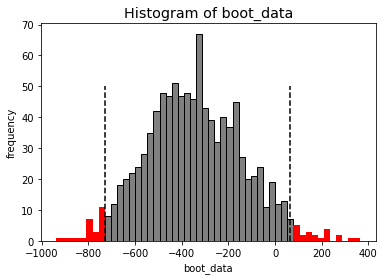

In [37]:
booted_data = get_bootstrap(control.revenue, test.revenue)

In [38]:
booted_data["p_value"]

0.09484409579553205

In [39]:
booted_data["quants"]

,0
0.025,-730.825337
0.975,63.243309


__Вывод:__ Т.к. по результатам теста - 0 входит в доверительный интервал и значение p.val > 0.05, значит причин отклонять нулевую гипотезу у нас нет.
Для оценки статистической значимости различий в группах лучше всего использовать метрику ARPPU, так как пользователей не совершавщих покупку слишком много. Исходя из данных, для статистического теста мы использовали метод bootsprap, отобрав из выборок данные только по платившим пользователям. По результатам теста мы не можем отклонить нулевую гипотезу, о том, что различий между группами не обнаружено, однако, судя по распределению выборок в тестовой группе основная часть пользователей приносит больше выручки, чем в контрольной, а в контрольной группе есть существенные выбросы. Возможно, необходимо перепроверить систему сплитования и заново провести тест.     
Если предположить, что данные верные, то я бы рассуждала в таком ключе: в тестовой и контрольной группе нет стат. различий, но имеются существенные различия в медианах (311 против 3022), в контрольной группе два типа клиентов (группа с большой суммой покупки и группа с недорогими покупками), а в тестовой группе более стабильные покупки, нет таких перекосов.
Если отвечать на вопрос, какой вариант лучше, то все зависит от стратегии самой компании. Как аналитик, я могу сказать, что
-контрольная группа - подразумевает работу с 2 группами клиентов-вип и простые покупатели, а это, соответственно, говорит о том, что компании необходимо будет разрабатывать предложения для 2 абсолютно разных целевых аудиторий. Уход любого крупного клиента ударит по выручке
-тестовая группа- клиенты примерно равны, подход к ним, скорее всего, нужен схожий. Уход клиента не так катастрофичен для компании.
Решение необходимо принимать руководству, исходя из их стратегии на рынке. Если бы я выбирала, то выбрала бы второй вариант (тестовая групппа), т.к. он менее рискованный и, возможно, менее затратный.

---

# Задание 3    
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

__По первому вопросу:__    
Конверсия (CR) — отношение числа пользователей, которые выполнили какое-либо целевое действие к общему числу 
пользователей в тематические и обычные дни  
Retention - удержание пользователя в определенные дни (например, на 7-й, 14-й, 21-й) с учетом тематического события     
DAU, WAU, MAU - количество уникальных пользователей за сутки/неделю/месяц в тематические и в обычные дни   
ARPU и ARPPU - отслеживание транзакций во время события для получения дополнительных наград

__По второму вопросу:__    
Churn rate - как изменился отток клиентов после неудачной попытки    
Среднее количество неудачных попыток на пользователя    
Уровень, на котором происходит наибольший отток клиентов    
Количество удалений игры после понижения уровня    
Сравнение среднего времени нахождения в игре до внесения изменений и после внесения изменений